<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 3
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[-0.71611434  0.4489629   0.27404615 -0.9834625   0.37145188]
 [-1.12642    -0.5751261  -0.55118793  0.15826419  0.46431756]
 [ 0.17371619 -1.3394618   0.14829169  0.24760346  0.6260575 ]
 [ 0.2704591  -1.2554212   1.7203774   1.2534722   0.8363086 ]
 [ 0.4502559   2.196639   -1.1433518   0.24345477 -0.5309939 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


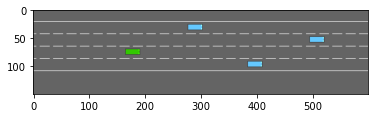

[[ 1.          0.8879762   0.5         0.3125      0.        ]
 [ 1.          0.10103771 -0.5        -0.02180158  0.        ]
 [ 1.          0.19824308  0.25       -0.04466243  0.        ]
 [ 1.          0.2992122  -0.25       -0.04763457  0.        ]
 [ 1.          0.403103    0.         -0.04101941  0.        ]]

Acción: SLOWER -> recommpensa: 0.7338962090612631
Nuevo estado:


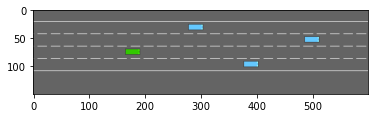

[[ 1.00000000e+00  1.00000000e+00  5.00000000e-01  2.60680526e-01
   0.00000000e+00]
 [ 1.00000000e+00  1.01841718e-01 -5.00000000e-01  1.38452975e-02
   0.00000000e+00]
 [ 1.00000000e+00  1.91837981e-01  2.50000000e-01  1.70202949e-03
   0.00000000e+00]
 [ 1.00000000e+00  2.91763723e-01 -2.50000000e-01 -3.90557980e-04
   0.00000000e+00]
 [ 1.00000000e+00  3.97983074e-01  0.00000000e+00 -1.29935783e-04
   0.00000000e+00]]

Acción: IDLE -> recommpensa: 0.7150048162755963
Nuevo estado:


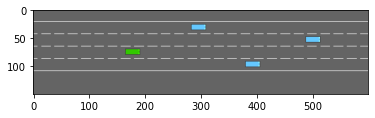

[[ 1.          1.          0.5         0.25182518  0.        ]
 [ 1.          0.10691518 -0.5         0.00939511  0.        ]
 [ 1.          0.19460802  0.25        0.01088256  0.        ]
 [ 1.          0.29327065 -0.25        0.00614922  0.        ]
 [ 1.          0.39784792  0.         -0.00190492  0.        ]]

Acción: FASTER -> recommpensa: 0.822324734896006
Nuevo estado:


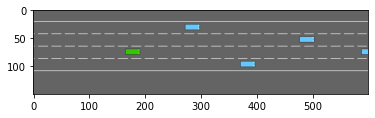

[[ 1.          1.          0.5         0.30213138  0.        ]
 [ 1.          0.09652952 -0.5        -0.05083687  0.        ]
 [ 1.          0.1868245   0.25       -0.04061944  0.        ]
 [ 1.          0.2832872  -0.25       -0.04533862  0.        ]
 [ 1.          0.3837005   0.         -0.05818549  0.        ]]

Acción: LANE_LEFT -> recommpensa: 0.8184422241070465
Nuevo estado:


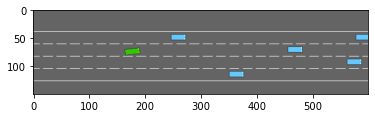

[[ 1.          1.          0.29078707  0.30885625 -0.03405561]
 [ 1.          0.07382414 -0.29078707 -0.06511736  0.03405561]
 [ 1.          0.16897275  0.45921293 -0.05067441  0.03405561]
 [ 1.          0.26413068 -0.04078706 -0.05266114  0.03405561]
 [ 1.          0.36028486  0.20921294 -0.05910895  0.03405561]]

Acción: FASTER -> recommpensa: 0.932124500400611
Nuevo estado:


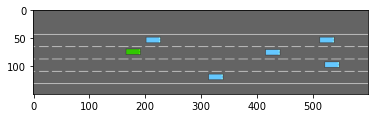

[[ 1.00000000e+00  1.00000000e+00  2.32782379e-01  3.64015967e-01
   7.33717636e-04]
 [ 1.00000000e+00  3.30909155e-02 -2.32782379e-01 -1.26180232e-01
  -7.33717636e-04]
 [ 1.00000000e+00  1.34840518e-01  5.17217636e-01 -1.07427485e-01
  -7.33717636e-04]
 [ 1.00000000e+00  2.27486402e-01  1.72176287e-02 -1.20167859e-01
  -7.33717636e-04]
 [ 1.00000000e+00  3.16209614e-01 -2.32782379e-01 -1.62764475e-01
  -7.33717636e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.9737736861269216
Nuevo estado:


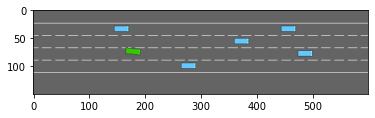

[[ 1.          1.          0.45651752  0.37128937  0.03694628]
 [ 1.         -0.01907814 -0.45651752 -0.13623244 -0.03694628]
 [ 1.          0.09063492  0.29348248 -0.11548033 -0.03694628]
 [ 1.          0.17687058 -0.20651752 -0.1342984  -0.03694628]
 [ 1.          0.253152   -0.45651752 -0.15430841 -0.03694628]]

Acción: IDLE -> recommpensa: 0.9770935256242819
Nuevo estado:


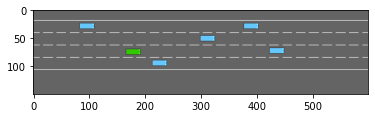

[[ 1.00000000e+00  1.00000000e+00  5.17079532e-01  3.74678046e-01
  -9.47570545e-04]
 [ 1.00000000e+00  4.33936268e-02  2.32920453e-01 -1.19228214e-01
   9.47570545e-04]
 [ 1.00000000e+00  1.21572144e-01 -2.67079532e-01 -1.40460566e-01
   9.47570545e-04]
 [ 1.00000000e+00  1.92612991e-01 -5.17079532e-01 -1.46918982e-01
   9.47570545e-04]
 [ 1.00000000e+00  2.34270155e-01 -1.70795470e-02 -1.14875004e-01
   9.47570545e-04]]

Acción: SLOWER -> recommpensa: 0.8671126117520463
Nuevo estado:


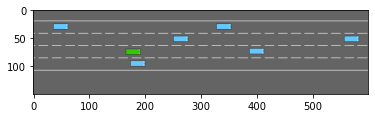

[[ 1.          1.          0.50266397  0.32311848 -0.00216012]
 [ 1.          0.00817407  0.24733603 -0.06781118  0.00216012]
 [ 1.          0.07769314 -0.25266397 -0.08972305  0.00216012]
 [ 1.          0.14776759 -0.50266397 -0.08831152  0.00216012]
 [ 1.          0.20100641 -0.00266397 -0.06244579  0.00216012]]

Acción: LANE_RIGHT -> recommpensa: 0.06666666666666665
Nuevo estado:


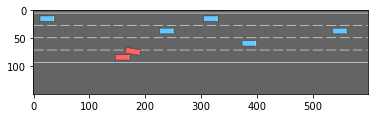

[[ 1.          1.          0.66810215  0.19297089  0.03042854]
 [ 1.         -0.01639266  0.11809959 -0.04163959 -0.03042854]
 [ 1.          0.05503775 -0.41810215  0.04058455 -0.03042854]
 [ 1.          0.1265742  -0.66810215  0.04631693 -0.03042854]
 [ 1.          0.18933906 -0.16810213  0.06809094 -0.03042854]]
Episodio terminado después de 9 pasos y la recompensa fue 6.906438974910439


In [8]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [9]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [131]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(state)  # acción del cálculo de Q para esta acción
#             print(state)
#             print(qvals)
#             print(state[0])
#             print(self.get_qvals(state[0]))
#             action= torch.max(qvals, dim=-1)[1].item()
            action= torch.max(qvals[0], dim=-1)[1].item()
#             print(action)
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
#             print("*******************")
#             print("ACTUALIZCION")
#             print(state)
#             state = np.array([np.ravel(s) for s in state])
#             print(state)
#             print("*******************")
            lista = []
            for s in state:
                lista.append(s)
            state = np.array(lista)
        state_t = torch.FloatTensor(state)
        return self.model(state_t)  

Luego tenemos que crear el agente:

In [132]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
#                     if mean_rewards >= self.reward_threshold:
#                         training = False
#                         print('\nEnvironment solved in {} episodes!'.format(
#                             episode))
#                         break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

    
    def getQ(qvalues):
        
                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        print(states)
        print("*******************")
        print(actions)
        print("*******************")
        print(actions_vals)
        print("*******************")
        aux1 = self.main_network.get_qvals(states) 
        print(aux1)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [133]:
# Definición de los hiperparámetros
lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 32       # Tamaño del batch
MAX_EPISODES = 5000   # Número de episodios
BURN_IN = 30        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.99          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [134]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...
(array([[ 1.        ,  0.9129914 ,  0.        ,  0.3125    ,  0.        ],
       [ 1.        ,  0.10992516,  0.75      , -0.03899418,  0.        ],
       [ 1.        ,  0.2139314 ,  0.25      , -0.04853057,  0.        ],
       [ 1.        ,  0.3258597 ,  0.5       , -0.02142795,  0.        ],
       [ 1.        ,  0.41954118,  0.75      , -0.03356429,  0.        ]],
      dtype=float32), array([[ 1.0000000e+00,  1.0000000e+00,  7.5000000e-01,  2.5000182e-01,
         0.0000000e+00],
       [ 1.0000000e+00,  2.5979714e-02, -2.5000000e-01,  3.1719066e-02,
         3.9924042e-10],
       [ 1.0000000e+00,  8.4599458e-02, -2.0757529e-10,  3.4087964e-03,
         2.1864266e-10],
       [ 1.0000000e+00,  1.7799485e-01, -7.5000000e-01, -4.7481712e-03,
         2.4980018e-12],
       [ 1.0000000e+00,  2.8250137e-01, -5.0000000e-01,  8.9859543e-03,
         9.8496766e-12]], dtype=float32), array([[ 1.0000000e+00,  1.0000000e+00,  7.5000000e-01,  2.5031191e

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [72]:
a = np.array([[ 1.          ,0.88767046  ,0.          ,0.3125      ,0.        ],
              [ 1.          ,0.09806664  ,0.25       ,-0.03906327  ,0.        ],
              [ 1.          ,0.20150366  ,0.         ,-0.02257037  ,0.        ],
              [ 1.          ,0.31406704  ,0.75       ,-0.02088534  ,0.        ],
              [ 1.          ,0.41759038  ,0.         ,-0.03957855  ,0.        ]])
print(a.shape)

a[0]

(5, 5)


array([1.        , 0.88767046, 0.        , 0.3125    , 0.        ])